In [1]:
import skdim
import pandas as pd
import hvplot.pandas
import seaborn as sns
import matplotlib.pyplot as plt
import panel as pn
from tqdm.auto import tqdm
import plotly.express as px
import xarray as xr
import os.path as osp
from utils.basics import PNAS2015_subject_list,input_datas,norm_methods, PRJ_DIR
norm_methods_labels_dict = {'asis':'None','zscored':'Z-score'}
from statannotations.Annotator import Annotator

In [2]:
import os
port_tunnel = int(os.environ['PORT2'])

In [3]:
wls = 45
wss = 1.5

***
# Global Intrinsic Dimension

In [18]:
ID_global = pd.DataFrame(columns=['SBJ','Input','Data Normalization','ID Estimator','Global ID'])
for subject in PNAS2015_subject_list:
    for input_data in input_datas:
        for norm_method in norm_methods:
            out_path_global  = osp.join(PRJ_DIR,'Data_Interim','PNAS2015',subject,'ID_estimates',input_data,'{subject}_Craddock_0200.WL{wls}s.WS{wss}s.tvFC.Z.{nm}.global_ID.pkl'.format(subject=subject,nm=norm_method,wls=str(int(wls)).zfill(3), wss=str(wss)))
            aux_global       = pd.read_pickle(out_path_global)
            ID_global        = ID_global.append({'SBJ':subject,'Input':input_data,'Data Normalization':norm_methods_labels_dict[norm_method],'ID Estimator':'Local PCA','Global ID':aux_global['lpca_global']},ignore_index=True)
            ID_global        = ID_global.append({'SBJ':subject,'Input':input_data,'Data Normalization':norm_methods_labels_dict[norm_method],'ID Estimator':'Two NN','Global ID':aux_global['twoNN_global']},ignore_index=True)
            ID_global        = ID_global.append({'SBJ':subject,'Input':input_data,'Data Normalization':norm_methods_labels_dict[norm_method],'ID Estimator':'Fisher Separability','Global ID':aux_global['fisherS_global']},ignore_index=True)
ID_global = ID_global.set_index(['Input','SBJ']).sort_index()

In [19]:
ID_global_means = ID_global.loc['Original'].groupby(['Data Normalization','ID Estimator']).mean().round(2)

In [20]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
sns.set(font_scale=1.5, style='whitegrid')
aux_data = ID_global.loc['Original']
plot = sns.barplot(data=aux_data,y='Global ID',x='ID Estimator',hue='Data Normalization', ax=ax, palette=['black','gray'])
ax.set_title('Global Intrinsic Dimension')
plt.close()

Row
    [0] Matplotlib(Figure)
    [1] DataFrame(DataFrame)
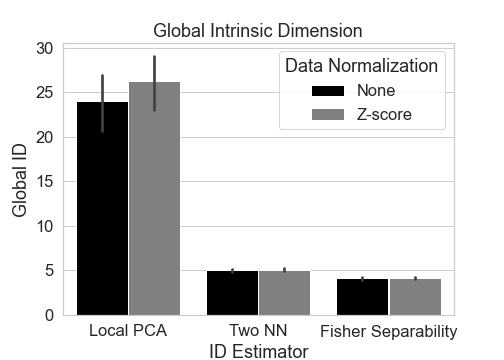

In [21]:
pn.Row(pn.pane.Matplotlib(fig), pn.pane.DataFrame(ID_global_means))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Local PCA_None vs. Two NN_None: t-test paired samples with Bonferroni correction, P_val:1.644e-09 t=1.196e+01
Two NN_None vs. Fisher Separability_None: t-test paired samples with Bonferroni correction, P_val:3.893e-07 t=8.521e+00
Local PCA_Z-score vs. Two NN_Z-score: t-test paired samples with Bonferroni correction, P_val:4.837e-10 t=1.285e+01
Two NN_Z-score vs. Fisher Separability_Z-score: t-test paired samples with Bonferroni correction, P_val:2.229e-07 t=8.836e+00
Local PCA_None vs. Fisher Separability_None: t-test paired samples with Bonferroni correction, P_val:4.305e-10 t=1.294e+01
Local PCA_Z-score vs. Fisher Separability_Z-score: t-test paired samples with Bonferroni correction, P_val:1.456e-10 t=1.378e+01


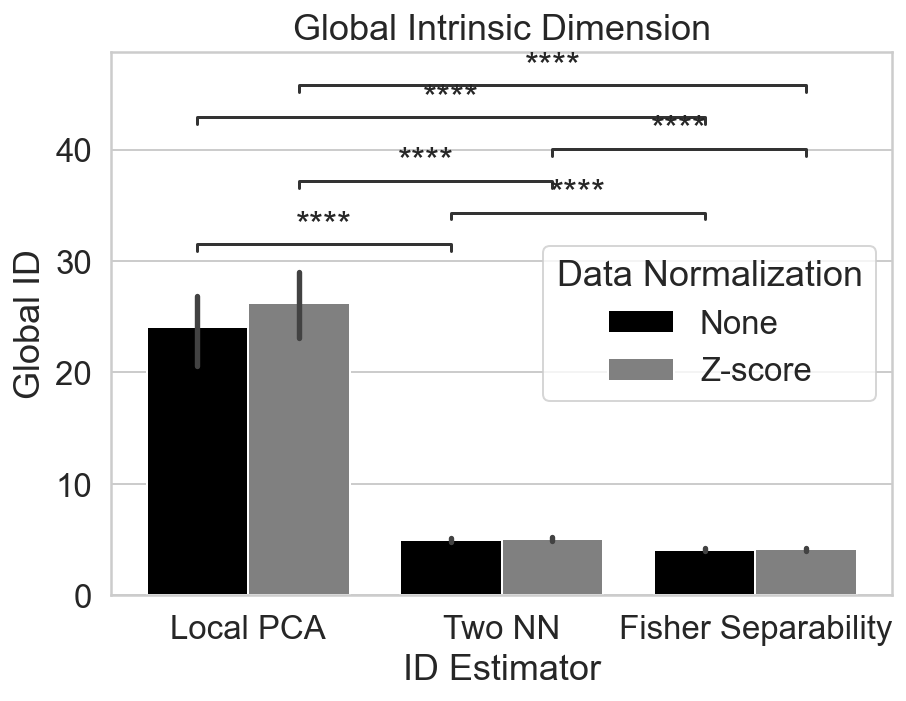

<Figure size 432x288 with 0 Axes>

In [22]:
pairs=[(('Local PCA','None'),('Two NN','None')),
       (('Local PCA','None'),('Fisher Separability','None')),
       (('Two NN','None'),('Fisher Separability','None')),
       (('Local PCA','Z-score'),('Two NN','Z-score')),
       (('Local PCA','Z-score'),('Fisher Separability','Z-score')),
       (('Two NN','Z-score'),('Fisher Separability','Z-score'))]
annot = Annotator(plot, pairs, data=aux_data, x='ID Estimator', y='Global ID', hue='Data Normalization')
annot.configure(test='t-test_paired', verbose=1, comparisons_correction='Bonferroni', text_format="star")
annot.apply_test()
annot.annotate()
fig

Although in absolute terms the IDglobal looks very similar between No-Norm and Z-score, there is actually a signficant difference. To understand where that was comming from I decided to plot values separately for each subject. It is clear that there is a very small but consistent

In [23]:
a = aux_data.reset_index().set_index(['SBJ','Data Normalization','ID Estimator']).sort_index().loc[:,'None','Local PCA'].values.squeeze()
b = aux_data.reset_index().set_index(['SBJ','Data Normalization','ID Estimator']).sort_index().loc[:,'Z-score','Local PCA'].values.squeeze()
pd.DataFrame([a,b]).T.hvplot.bar()

:Bars   [index,Variable]   (value)

***
# Local Intrinsic Dimension

In [24]:
ID_local = None
for subject in PNAS2015_subject_list:
    for norm_method in norm_methods:
        out_path_local  = osp.join(PRJ_DIR,'Data_Interim','PNAS2015',subject,'ID_estimates',input_data,'{subject}_Craddock_0200.WL{wls}s.WS{wss}s.tvFC.Z.{nm}.local_ID.pkl'.format(subject=subject,nm=norm_method,wls=str(int(wls)).zfill(3), wss=str(wss)))
        aux_local       = pd.read_pickle(out_path_local)
        task_list       = list(aux_local['Window Name'].values)
        if ID_local is None:
            ID_local = xr.DataArray(dims=['Data Normalization','Subject','ID Estimator','NN','Task'],
                        coords={'Data Normalization':['None','Z-score'],'Subject':PNAS2015_subject_list,
                                'ID Estimator':['Local PCA','Two NN','Fisher Separability'],
                                'NN':[25,50,75,100,125,150,200],
                                'Task':task_list})
            ID_local.name = 'Local ID'
        for m_label,m in zip(['lpca','twoNN','fisherS'],['Local PCA','Two NN','Fisher Separability']):
            for NN in [25,50,75,100,125,150,200]:
                ID_local.loc[norm_methods_labels_dict[norm_method],subject,m,NN,:] = aux_local[m_label+'_'+str(NN)].values
ID_local_df = ID_local.to_dataframe()

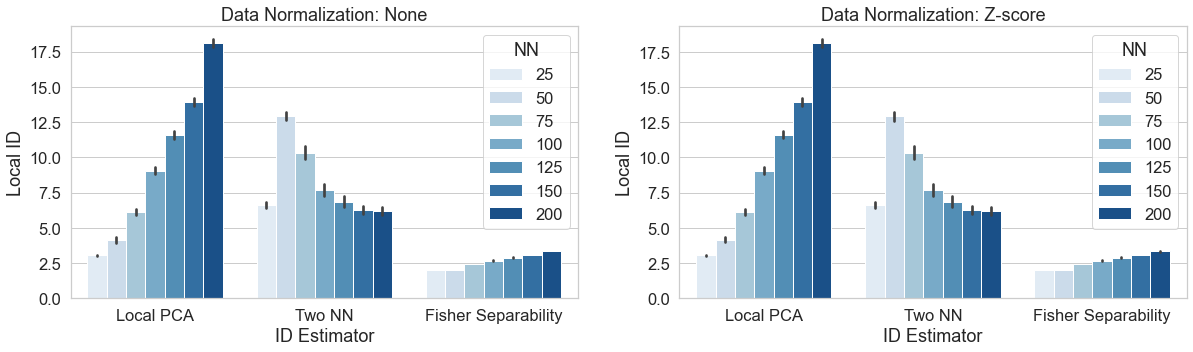

In [47]:
fig,axs = plt.subplots(1,2,figsize=(20,5))
for i,nm in enumerate(['None','Z-score']):
    aux_data = ID_local.loc[nm].groupby('Task').mean().to_dataframe()
    aux_data = aux_data.loc[aux_data.index.drop('XXXX',level='Task')]
    aux_data = ID_local_None_AvgByTask.reset_index()
    g = sns.barplot(data=aux_data,y='Local ID',x='ID Estimator', hue='NN',ax=axs[i], palette=sns.color_palette('Blues',7))
    axs[i].set_title('Data Normalization: %s' % nm)
    #pairs = [(('Local PCA',25),('Local PCA',50))]
    #annot = Annotator(g, pairs, data=aux_data, x='ID Estimator', y='Local ID', hue='NN')
    #annot.configure(test='t-test_paired', verbose=1, comparisons_correction='Bonferroni', text_format="star")
    #annot.apply_test()
    #annot.annotate()

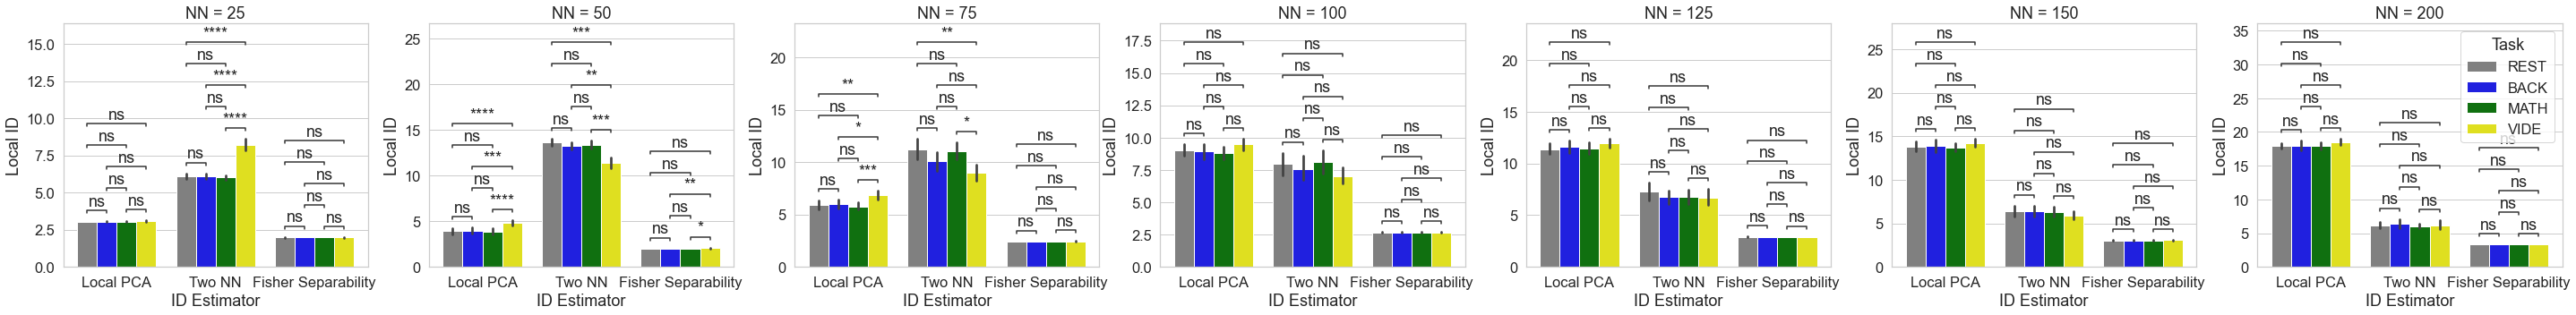

In [60]:
fig,axs = plt.subplots(1,7,figsize=(50,5))
for i,NN in enumerate([25,50,75,100,125,150,200]):
    aux_data = ID_local.loc[nm].groupby('Task').mean().to_dataframe()
    aux_data = aux_data.loc[aux_data.index.drop('XXXX',level='Task')]
    aux_data = ID_local_None_AvgByTask.reset_index()
    aux_data = aux_data.set_index('NN').loc[NN]    
    g        = sns.barplot(data=aux_data,y='Local ID',x='ID Estimator', hue='Task', ax=axs[i],palette=['gray','blue','green','yellow','black'], hue_order=['REST','BACK','MATH','VIDE'])
    if i < 6:
        axs[i].legend([],[],frameon=False)
    axs[i].set_title('NN = %d'% NN)
    pairs=[(('Local PCA','REST'),('Local PCA','BACK')),
           (('Local PCA','REST'),('Local PCA','MATH')),
           (('Local PCA','REST'),('Local PCA','VIDE')),
           (('Local PCA','BACK'),('Local PCA','MATH')),
           (('Local PCA','BACK'),('Local PCA','VIDE')),
           (('Local PCA','MATH'),('Local PCA','VIDE')),
           (('Two NN','REST'),('Two NN','BACK')),
           (('Two NN','REST'),('Two NN','MATH')),
           (('Two NN','REST'),('Two NN','VIDE')),
           (('Two NN','BACK'),('Two NN','MATH')),
           (('Two NN','BACK'),('Two NN','VIDE')),
           (('Two NN','MATH'),('Two NN','VIDE')),
           (('Fisher Separability','REST'),('Fisher Separability','BACK')),
           (('Fisher Separability','REST'),('Fisher Separability','MATH')),
           (('Fisher Separability','REST'),('Fisher Separability','VIDE')),
           (('Fisher Separability','BACK'),('Fisher Separability','MATH')),
           (('Fisher Separability','BACK'),('Fisher Separability','VIDE')),
           (('Fisher Separability','MATH'),('Fisher Separability','VIDE')),]
    annot = Annotator(g, pairs, data=aux_data, x='ID Estimator', y='Local ID', hue='Task', hue_order=['REST','BACK','MATH','VIDE'])
    annot.configure(test='t-test_paired', verbose=False, comparisons_correction='bonf', text_format='star')#, pvalue_thresholds=[[0.01,"**"],[0.05, "*"], [1, "ns"]])
    annot.apply_test()
    annot.annotate()

In [73]:
a = ID_local.loc['None'].groupby('Task').mean()

In [76]:
a.to_dataframe().sort_values(by='Local ID', ascending=False).head(1)

,,,,Data Normalization,Local ID
Subject,ID Estimator,NN,Task,,
SBJ09,Local PCA,200,BACK,None,21.252747


In [78]:
a.to_dataframe().sort_values(by='Local ID', ascending=True).head(1)

,,,,Data Normalization,Local ID
Subject,ID Estimator,NN,Task,,
SBJ06,Fisher Separability,50,VIDE,None,1.913484
